# Лабораторна робота 3: Знайомство з нейромережами

## 1. Повнозв'язані нейронні мережі

Задача класифікації береться із першої лабораторної:

Той самий [датасет](https://archive.ics.uci.edu/dataset/763/land+mines-1) з показниками детектора мін для різних типів грунту, та різних типів наземних мін із лабораторної 1.

![table1](extras\table1.png "table2")

До характеристики грунту було застосовано "One-Hot" кодування.

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler


data = pd.read_csv("data\mine_data_norm.csv")

# Separate into separate Wet/Dry and Soil type
data['SH'] = (data.loc[:, 'S'] > 0.5).astype(float)
data['ST'] = (data.loc[:, 'S'] * 10) % 6

# One-Hot-Encoding of Soil types
enc_s = OneHotEncoder()
data[['Sandy', 'Humus', 'Limy']] = enc_s.fit_transform(data[['ST']]).toarray()

# Table cleaning
DF = data.drop(['ST', 'S'], axis=1)
DF = DF.drop(['M'], axis=1).join(DF['M'])
DF = DF.rename(columns={'V': 'Voltage', 'H': 'Height', 'SH': 'Humidity', 'M': 'Mine'})
DF['Mine'] = DF['Mine'] - 1

DF.head()

,Voltage,Height,Humidity,Sandy,Humus,Limy,Mine
0,0.338157,0.000000,0.0,1.0,0.0,0.0,0
1,0.320241,0.181818,0.0,1.0,0.0,0.0,0
2,0.287009,0.272727,0.0,1.0,0.0,0.0,0
3,0.256284,0.454545,0.0,1.0,0.0,0.0,0
4,0.262840,0.545455,0.0,1.0,0.0,0.0,0


Розіб'ємо дані на два піднабори — тренувальний та тестовий:

In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter

X = DF.drop(['Mine'], axis=1)
Y = DF['Mine']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
Counter(Y_train)

Counter({0: 49, 3: 49, 4: 48, 1: 46, 2: 44})

### Будуємо модель

На вхід — 6 нейронів (вектор із 6 значень)


На вихід — 5 нейронів (5 можливих класів)



2 проміжних шари по 300 нейронів з функцією активації ReLU

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential(
    [
        keras.layers.Input(shape=(6, )),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(trainable=True),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(trainable=True),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(5, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,305 (376.19 KB)

 Trainable params: 95,105 (371.50 KB)

 Non-trainable params: 1,200 (4.69 KB)

In [4]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
history = model.fit(X_train,
                    Y_train,
                    epochs=50,
                    batch_size=125,                                   
                    validation_data=(X_test, Y_test))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.2272 - loss: 2.4455 - val_accuracy: 0.2647 - val_loss: 1.6046
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3017 - loss: 1.7912 - val_accuracy: 0.2941 - val_loss: 1.5986
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3105 - loss: 1.6864 - val_accuracy: 0.2941 - val_loss: 1.5920
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4212 - loss: 1.4490 - val_accuracy: 0.2843 - val_loss: 1.5867
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3548 - loss: 1.5389 - val_accuracy: 0.2843 - val_loss: 1.5811
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3987 - loss: 1.3995 - val_accuracy: 0.3137 - val_loss: 1.5767
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4657 - loss: 1.2969 - val_accuracy: 0.3137 - val_loss: 1.5732
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4519 - loss: 1.2521 - val_accuracy: 0.3137 - val_loss: 1.5707

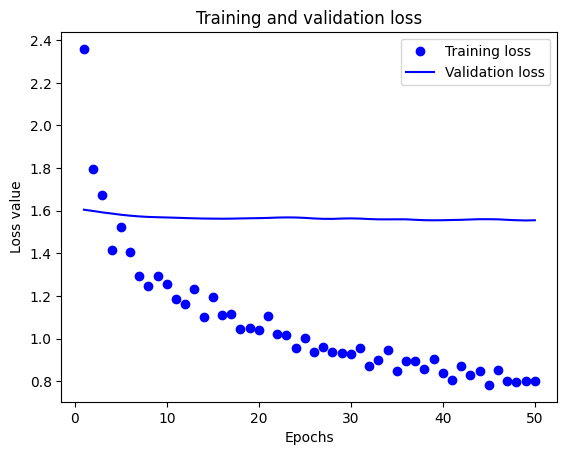

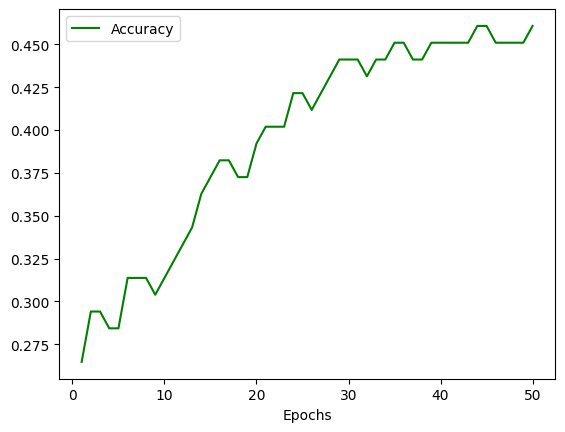

In [6]:
import matplotlib.pyplot as plt

history_dict = history.history

epochs = range(1, len(history_dict["loss"]) + 1)
plt.plot(epochs, history_dict["loss"], "bo", label="Training loss")
plt.plot(epochs, history_dict["val_loss"], "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.show()

plt.plot(epochs, history_dict["val_accuracy"], "g", label="Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Дуже маленький датасет :(

In [7]:
score = model.evaluate(X_test, Y_test, verbose=0) 
print('Inference accuracy:', score[1])

Inference accuracy: 0.46078431606292725


## Завдання 2: Згорткові нейронні мережі